# Вводная часть

В этом ноутбуке будем дообучать LoRA (спасибо, ведь ее проще дообучать) методом DreamBooth под нетипичный домен, а именно куклу nendroid моего любимого перса. Как мы увидим позже, изначальная модель понимает основную структуру данного объекта, но выглядит не так правдопадобно, по сравнению с теми же людьми и животными.

Фото взял из интернета и обрезал до разрешения 512x512, так как они должны быть одинакового размера со сгенерированными

Пообучаем несколько раз с разными гиперпараметрами и попробуем поинферить на изменение контекста.

# Загрузка домена

In [1]:
!gdown --fuzzy https://drive.google.com/file/d/16kyYL3MAGjlzAjs8zDTYeKj4o0Jfr2Ys/view?usp=sharing -O nendroid_kacchan.zip

Downloading...
From: https://drive.google.com/uc?id=16kyYL3MAGjlzAjs8zDTYeKj4o0Jfr2Ys
To: /content/nendroid_kacchan.zip
100% 360k/360k [00:00<00:00, 128MB/s]


In [2]:
!unzip nendroid_kacchan.zip

Archive:  nendroid_kacchan.zip
  inflating: img/nendroid_1.jpg      
  inflating: img/nendroid_2.jpg      
  inflating: img/nendroid_3.jpg      
  inflating: img/nendroid_4.jpg      
  inflating: img/nendroid_5.jpg      
  inflating: img/nendroid_6.jpg      
  inflating: img/nendroid_7.jpg      


Вот так выглядит данный красавец

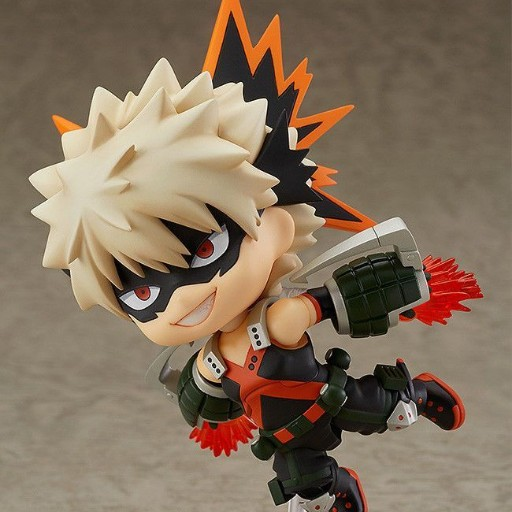

In [4]:
import os
from PIL import Image

folder = './img'
images = os.listdir(folder)

img = Image.open(os.path.join(folder, images[1]))
img

# Детерминируем результаты

In [5]:
import numpy as np
import torch
import random

In [6]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


In [7]:
set_seed()

Random seed set as 42


# Установка

In [8]:
from IPython.display import clear_output

In [9]:
!git clone https://github.com/cloneofsimo/lora.git && sed -i 's/functools.cache/functools.lru_cache(maxsize=None)/g' /content/lora/lora_diffusion/xformers_utils.py && pip install /content/lora
!pip install accelerate bitsandbytes
clear_output()

В этом репозе есть проблемка. С момента публикации библиотека accelerate успела кучу раз обновиться, теперь в конструкторе класса Accelerator убрали параметр **logging_dir**, из-за чего код просто так не запустится.

 Посмотрев документацию и исходный код репозитория, заменим в файле **train_lora dreambooth.py** в 493 строке параметр *logging_dir* на *project_dit* и все заработает

In [10]:
file_path = './lora/training_scripts/train_lora_dreambooth.py'
num_line = 493

with open(file_path, "r") as file:
    content = file.readlines()

content[num_line - 1] = content[num_line - 1].replace('logging_dir', 'project_dir', 1)

with open(file_path, "w") as file:
    file.write(''.join(content))

del content

# Обучение 1

Заметил тут странную вещь в изначальном виде ноутбука. Мы ведь обучаем как *dreambooth*, однако далее в команде не был прописан флаг добавления prior_preservation loss, являющейся отличительной чертой. Мб эта была джокушка ловушкера 🤔

Итого нам нужно добавить флаг *with_prior_preservation*, а также директорию для изображении класса и промпт для этого самого класса. Последние двое нужны как раз для второго слагаемого в loss. Судя по коду, данная предобученная text2img модель нагенерирует изображения в эту папку перед обучением, после использует их.

По умолчанию количество таких изображении будет 100. В статье используют 1000, но указано, что можно и меньше. Так и оставим

За редкий токен возьму **tion**  

In [11]:
import os
import shutil
from google.colab import files
from tqdm import tqdm

PRETRAINED_MODEL="runwayml/stable-diffusion-v1-5" #@param{type: 'string'}
PROMPT="A tion nendroid " #@param{type: 'string'}

OUTPUT_DIR="personalized_nendroid_kacchan" #@param{type: 'string'}
IMAGES_FOLDER_OPTIONAL="img" #@param{type: 'string'}

#добавим нужные флаги
CLASS_DATA_DIR="nendroid_folder" #@param{type: 'string'}
CLASS_PROMPT="A nendroid" #@param{type: 'string'}

RESOLUTION="512" #@param ["512", "576", "640", "704", "768", "832", "896", "960", "1024"]
RESOLUTION=int(RESOLUTION)

if PRETRAINED_MODEL == "":
  print('[1;31mYou should define the pretrained model.')

else:
  if IMAGES_FOLDER_OPTIONAL=="":
    INSTANCE_DIR = "/content/data_example"
    if not os.path.exists(str(INSTANCE_DIR)):
      %mkdir -p "$INSTANCE_DIR"
    uploaded = files.upload()
    for filename in tqdm(uploaded.keys(), bar_format='  |{bar:15}| {n_fmt}/{total_fmt} Uploaded'):
        shutil.move(filename, INSTANCE_DIR)
  else:
    INSTANCE_DIR = IMAGES_FOLDER_OPTIONAL

  if OUTPUT_DIR == "":
    OUTPUT_DIR = "/content/output"
  if not os.path.exists(str(OUTPUT_DIR)):
    %mkdir -p "$OUTPUT_DIR"

Тут теперь следует подумать насчет параметров обучения. Не стоит трогать:


1.   FP-16, он отвечает за точность весов, чем меньше точность, тем легче модель. В данном случае без значительной потери в качестве
2.   TRAIN_TEXT_ENCODER, так как мы привязываем наш объект к идентификатору в виде редкого токена, то есть меняем его значение. Поэтому дообучение text_encoder следует оставить

batch_size особо сильно не влияет, это зависит от памяти GPU. Просто чем больше batch_size, тем менее дерганной будет траектория оптимизации.

Steps в статье берется за 1000, не вижу смысла делать меньше

Остаются параметры, отвечающие за скорость обучения. В статье для stable diffusion берут 5e-6. Text_encoder возьму за 3e-4



In [12]:
STEPS = 1000 #@param {type:"slider", min:0, max:10000, step:10}
BATCH_SIZE = 8 #@param {type:"slider", min:0, max:128, step:1}
FP_16 = True #@param {type:"boolean"}

#@markdown ----
#@markdown UNET PARAMS
LEARNING_RATE = 5e-6 #@param {type:"number"}

#@markdown ----
TRAIN_TEXT_ENCODER = True #@param {type:"boolean"}
#@markdown TEXT ENCODER PARAMS
LEARNING_RATE_TEXT_ENCODER = 3e-4 #@param {type:"number"}

NEW_LEARNING_RATE = LEARNING_RATE / BATCH_SIZE
NEW_LEARNING_RATE_TEXT_ENCODER = LEARNING_RATE_TEXT_ENCODER / BATCH_SIZE

if FP_16:
  fp_16_arg = "fp16"
else:
  fp_16_arg = "no"

if TRAIN_TEXT_ENCODER:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--class_data_dir="{CLASS_DATA_DIR}" '
             f'--class_prompt="{CLASS_PROMPT}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--with_prior_preservation '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--max_train_steps={STEPS} '
             f'--train_text_encoder '
             f'--lora_rank=16 '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER}')
else:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--with_prior_preservation '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--lora_rank=16 '
             f'--max_train_steps={STEPS} '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER}')
!rm -rf $INSTANCE_DIR/.ipynb_checkpoints
!{command}

2023-08-25 13:52:42.715757: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2023-08-25 13:52:49.689852: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Fetching 13 files:   0% 0/13 [00:00<?, ?it/s]
Fetching 13 files:   8% 1/13 [00:00<00:09,  1.22it/s]
































































































Fetching 13 files:  38% 5/13 [00:05<00:09,  1.13s/it]
Fetching 13 files: 100% 13/13 [00:23<00:00,  1.80s/it]
Loading pipeline components...: 100% 6/6 [00:05<00:00,  1.06it/s

Так выглядят куклы от модели

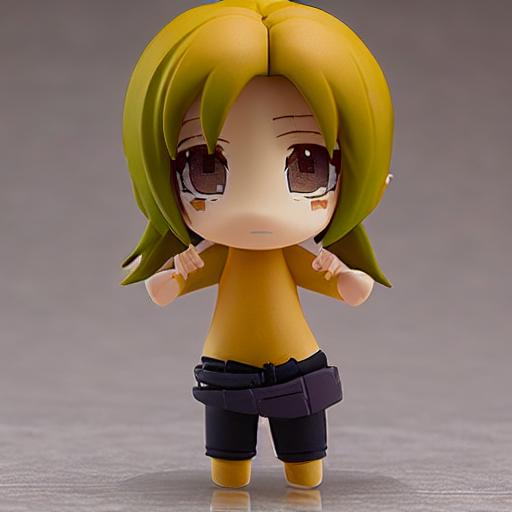

In [143]:
folder = './nendroid_folder'
images = os.listdir(folder)

img = Image.open(os.path.join(folder, images[1]))
img

## INFERENCE

In [13]:
import torch
from lora_diffusion import monkeypatch_or_replace_lora, tune_lora_scale
from diffusers import StableDiffusionPipeline


pipe = StableDiffusionPipeline.from_pretrained(PRETRAINED_MODEL, torch_dtype=torch.float16).to("cuda")
monkeypatch_or_replace_lora(pipe.unet, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.pt")))
monkeypatch_or_replace_lora(pipe.text_encoder, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.text_encoder.pt")), target_replace_module=["CLIPAttention"])

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [39]:
pipe.safety_checker = None

Теперь нужно думать об инференсе, ведь параметры здесь также сильно влияют на результат.

Путем проб и ошибок я выяснил, что при маленьком scale_unet абсолютно теряется привязка к объекту, выглядит как просто рандомная кукла. Аналогично со scale_text, если, например, пейзаж как то виден, то облик объекта попросту не соответствует. Параметр guidance, насколько я понимаю, должен отвечать за "своевольность" модели, чем меньше, тем более результат должен соответствовать описанию. Значение по середине оказалось самым удачным

  0%|          | 0/50 [00:00<?, ?it/s]

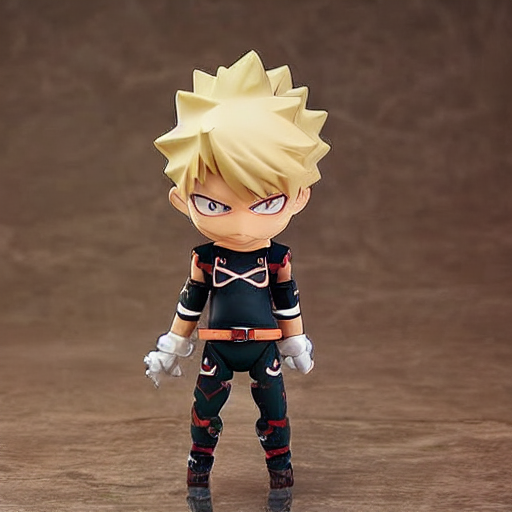

In [69]:
INFERENCE_PROMPT = 'A tion nendroid' #@param {type:"string"}
LORA_SCALE_UNET = 1 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 1.0 #@param {type:"number"}
GUIDANCE = 5 #@param {type:"slider", min:0, max:15, step:0.2}
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
if TRAIN_TEXT_ENCODER:
  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
image

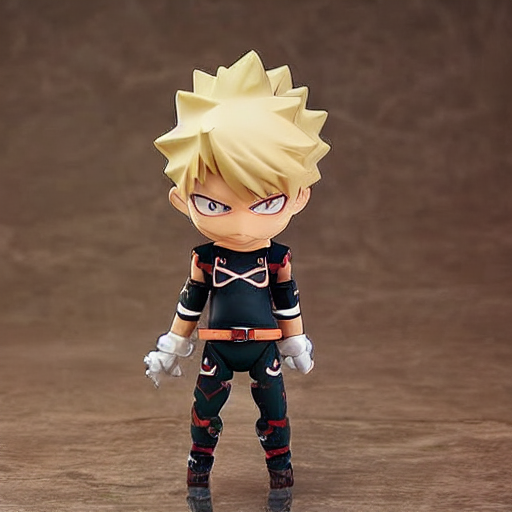

  0%|          | 0/50 [00:00<?, ?it/s]

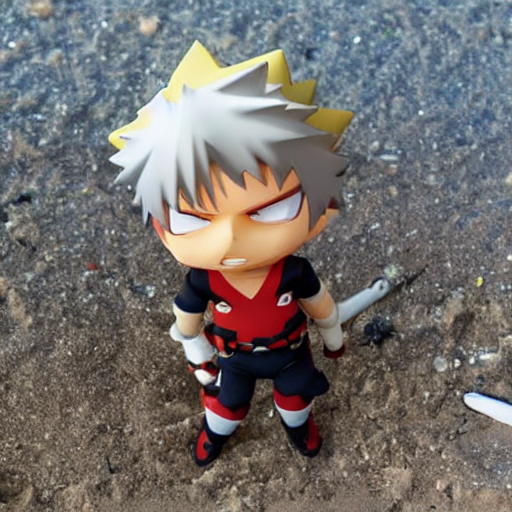

In [72]:
INFERENCE_PROMPT = 'A tion nendroid on the beach' #@param {type:"string"}
LORA_SCALE_UNET = 1 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 1.2 #@param {type:"number"}
GUIDANCE = 4 #@param {type:"slider", min:0, max:15, step:0.2}
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
if TRAIN_TEXT_ENCODER:
  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
image

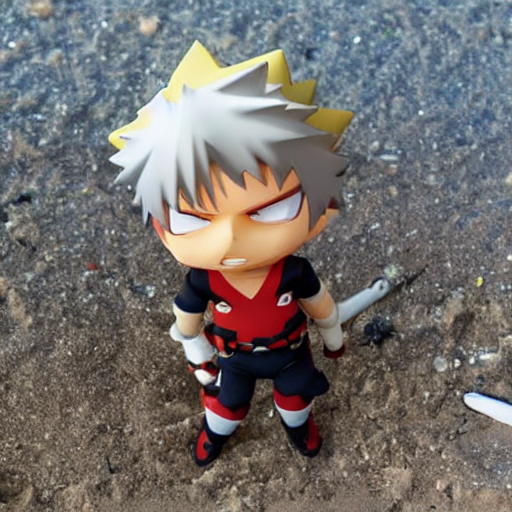

Результат не впечатлил, очевидные факторы уловил (острые клочки волос, разрез глаз, элементы одежды). Такое ощущение, что модель недообучилась

# Обучение 2

Решил добавить в промпт doll, хоть это вряд-ли повлияет сильно

In [75]:
import os
import shutil
from google.colab import files
from tqdm import tqdm

PRETRAINED_MODEL="runwayml/stable-diffusion-v1-5" #@param{type: 'string'}
PROMPT="A wzx nendroid doll" #@param{type: 'string'}

OUTPUT_DIR="personalized_2" #@param{type: 'string'}
IMAGES_FOLDER_OPTIONAL="img" #@param{type: 'string'}

#добавим нужные флаги
CLASS_DATA_DIR="nendroid2" #@param{type: 'string'}
CLASS_PROMPT="A nendroid doll" #@param{type: 'string'}

RESOLUTION="512" #@param ["512", "576", "640", "704", "768", "832", "896", "960", "1024"]
RESOLUTION=int(RESOLUTION)

if PRETRAINED_MODEL == "":
  print('[1;31mYou should define the pretrained model.')

else:
  if IMAGES_FOLDER_OPTIONAL=="":
    INSTANCE_DIR = "/content/data_example"
    if not os.path.exists(str(INSTANCE_DIR)):
      %mkdir -p "$INSTANCE_DIR"
    uploaded = files.upload()
    for filename in tqdm(uploaded.keys(), bar_format='  |{bar:15}| {n_fmt}/{total_fmt} Uploaded'):
        shutil.move(filename, INSTANCE_DIR)
  else:
    INSTANCE_DIR = IMAGES_FOLDER_OPTIONAL

  if OUTPUT_DIR == "":
    OUTPUT_DIR = "/content/output"
  if not os.path.exists(str(OUTPUT_DIR)):
    %mkdir -p "$OUTPUT_DIR"

Как я говорил ранее, похоже модель не дообучилась. Увеличим learning_rate до 3e-4. Также я посмотрел, как обычно обучают clip, который является encoder здесь. Там точность до стотысячных, поэтому возьму 1e-5

In [76]:
STEPS = 1000 #@param {type:"slider", min:0, max:10000, step:10}
BATCH_SIZE = 8 #@param {type:"slider", min:0, max:128, step:1}
FP_16 = True #@param {type:"boolean"}

#@markdown ----
#@markdown UNET PARAMS
LEARNING_RATE = 3e-4 #@param {type:"number"}

#@markdown ----
TRAIN_TEXT_ENCODER = True #@param {type:"boolean"}
#@markdown TEXT ENCODER PARAMS
LEARNING_RATE_TEXT_ENCODER = 1e-5 #@param {type:"number"}

NEW_LEARNING_RATE = LEARNING_RATE / BATCH_SIZE
NEW_LEARNING_RATE_TEXT_ENCODER = LEARNING_RATE_TEXT_ENCODER / BATCH_SIZE

if FP_16:
  fp_16_arg = "fp16"
else:
  fp_16_arg = "no"

if TRAIN_TEXT_ENCODER:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--class_data_dir="{CLASS_DATA_DIR}" '
             f'--class_prompt="{CLASS_PROMPT}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--with_prior_preservation '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--max_train_steps={STEPS} '
             f'--train_text_encoder '
             f'--lora_rank=16 '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER}')
else:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--with_prior_preservation '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--lora_rank=16 '
             f'--max_train_steps={STEPS} '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER}')
!rm -rf $INSTANCE_DIR/.ipynb_checkpoints
!{command}

2023-08-25 14:47:57.867258: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2023-08-25 14:48:04.284376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading pipeline components...: 100% 6/6 [00:21<00:00,  3.64s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applica

In [132]:
folder = './nendroid2'
images = os.listdir(folder)

img = Image.open(os.path.join(folder, images[1]))
img

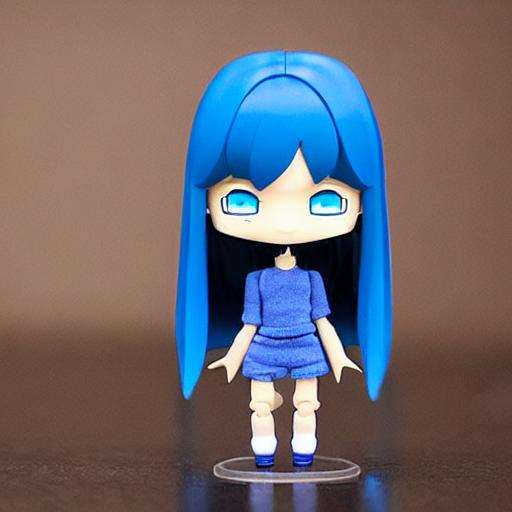

In [142]:
img = Image.open(os.path.join(folder, images[1]))
img

In [77]:
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
from lora_diffusion import monkeypatch_or_replace_lora, tune_lora_scale
from diffusers import StableDiffusionPipeline


pipe = StableDiffusionPipeline.from_pretrained(PRETRAINED_MODEL, torch_dtype=torch.float16).to("cuda")
monkeypatch_or_replace_lora(pipe.unet, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.pt")))
monkeypatch_or_replace_lora(pipe.text_encoder, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.text_encoder.pt")), target_replace_module=["CLIPAttention"])

pipe.safety_checker = None

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


## Inference 1

Сейчас куда лучше!

  0%|          | 0/50 [00:00<?, ?it/s]

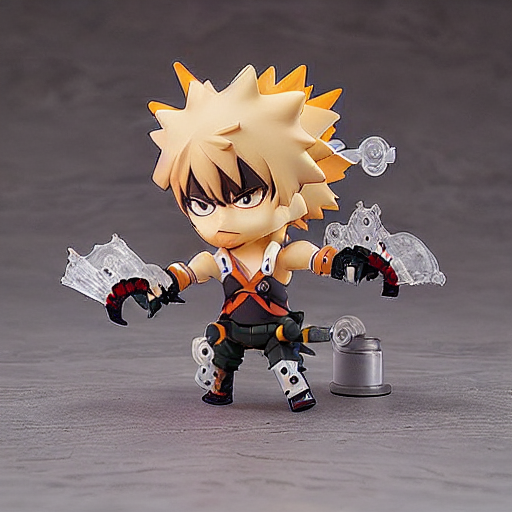

In [78]:
INFERENCE_PROMPT = 'A wzx nendroid' #@param {type:"string"}
LORA_SCALE_UNET = 1 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 1 #@param {type:"number"}
GUIDANCE = 4 #@param {type:"slider", min:0, max:15, step:0.2}
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
if TRAIN_TEXT_ENCODER:
  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
image

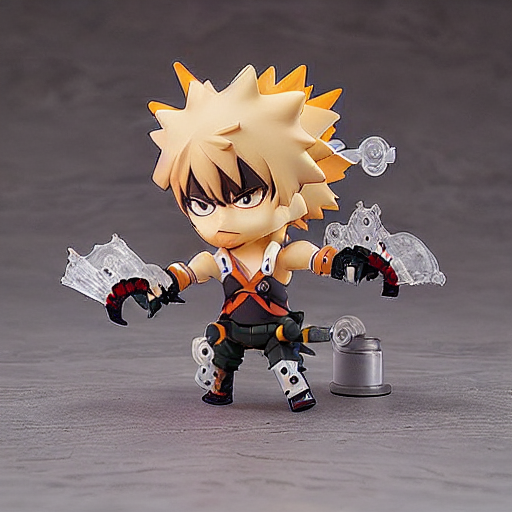

## Inference 2

Усложним задачу: добавим описание костюма и локации

  0%|          | 0/50 [00:00<?, ?it/s]

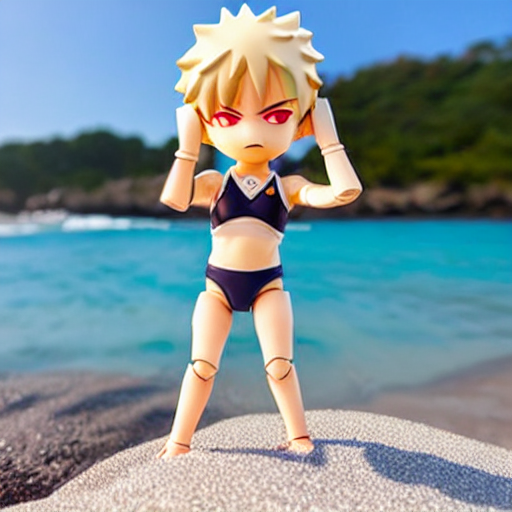

In [103]:
INFERENCE_PROMPT = 'A wzx nendroid in swim suit on the beach' #@param {type:"string"}
LORA_SCALE_UNET = 0.9 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 1.05 #@param {type:"number"}
GUIDANCE = 8 #@param {type:"slider", min:0, max:15, step:0.2}
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
if TRAIN_TEXT_ENCODER:
  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
image

Получилось при следующих параметрах

0.9 / 1.05 / 4

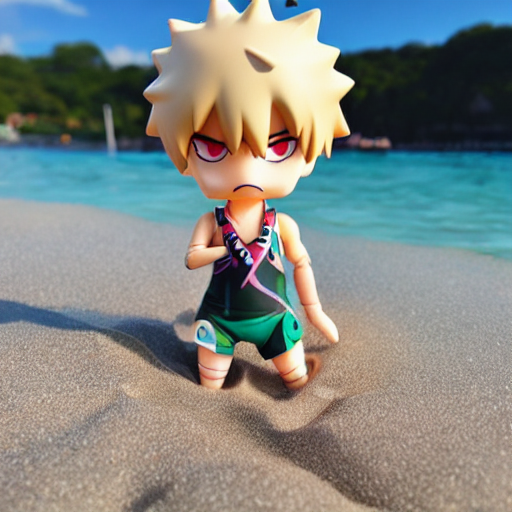

Получилось при следующих параметрах


0.9 / 1.05 / 8

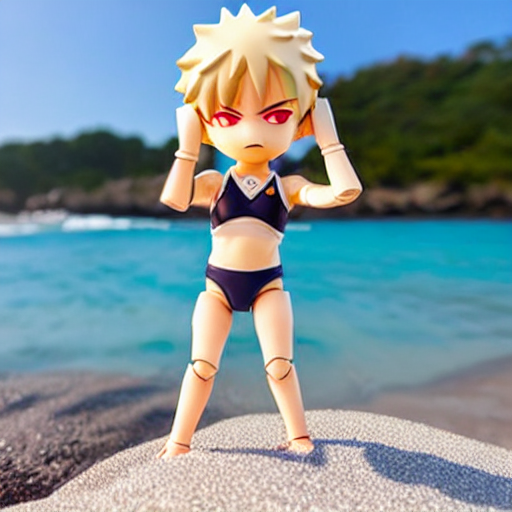

## Inference 3

  0%|          | 0/50 [00:00<?, ?it/s]

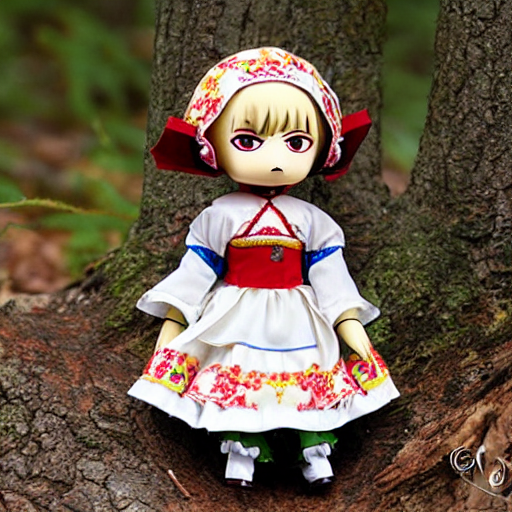

In [104]:
INFERENCE_PROMPT = 'A wzx nendroid doll in Russian folk costume in the forest' #@param {type:"string"}
LORA_SCALE_UNET = 0.9 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 1.05 #@param {type:"number"}
GUIDANCE = 8 #@param {type:"slider", min:0, max:15, step:0.2}
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
if TRAIN_TEXT_ENCODER:
  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
image

## Inference 4

Конечно забавно, что фейерверки в области рук, но это можно объяснить тем, что в обучающем домене было много взрывов в этой же области. У него тип причуда такая, производит взрывы!!! 🥰

  0%|          | 0/50 [00:00<?, ?it/s]

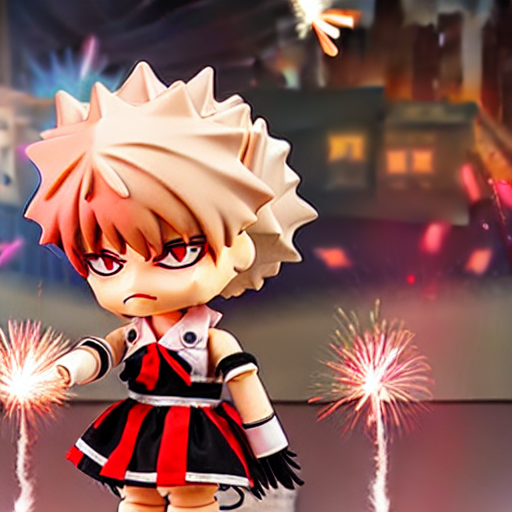

In [117]:
INFERENCE_PROMPT = 'A wzx nendroid doll in a maid costume on the background of fireworks' #@param {type:"string"}
LORA_SCALE_UNET = 0.9 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 1 #@param {type:"number"}
GUIDANCE = 7.8 #@param {type:"slider", min:0, max:15, step:0.2}
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
if TRAIN_TEXT_ENCODER:
  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

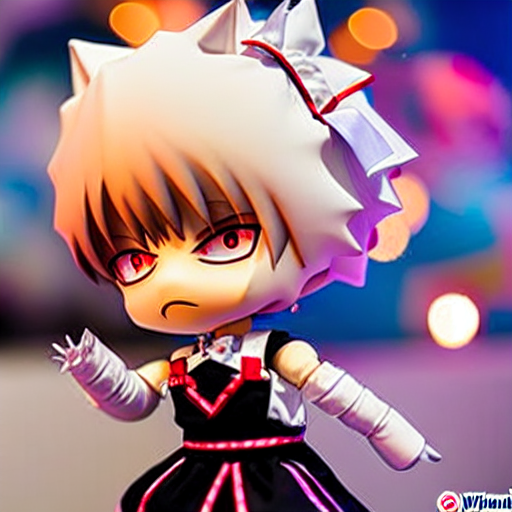

In [125]:
INFERENCE_PROMPT = 'A wzx nendroid doll in a maid costume on the background of fireworks' #@param {type:"string"}
LORA_SCALE_UNET = 0.9 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 1.1 #@param {type:"number"}
GUIDANCE = 8 #@param {type:"slider", min:0, max:15, step:0.2}
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
if TRAIN_TEXT_ENCODER:
  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
image

Как можно заметить, параметры инференса тут особо не менялись. Хорошие результаты получались при таких же значениях

# Выводы

Проведя данный эксперимент, можно убедиться в работоспособности данного механизма персонализации, тем более в его качестве и "дешевости". Я считаю, что полученные результаты сравнимы с опубликованными в интернете (ну по крайней мере с аналогичными, обученными в таких же условиях, точно не хуже). Нейросеть запоминает объект и способна синтезировать его в других сценах и ситуациях.